In [ ]:
using ITensors, ITensorMPS, Plots, LaTeXStrings
using ProgressMeter, Graphs, StatsBase
push!(LOAD_PATH, "../functions/")
using BP

In [79]:
"""
    contract_peps_no_phys(peps::Matrix{ITensor}; cutoff=1E-8, maxdim=100)

Approximately contracts a 2D PEPS tensor network that has no physical indices.
The network is contracted to a single scalar value (its norm).

The PEPS is contracted row-by-row from top to bottom using the boundary MPS method.
The first row is contracted into an MPS. Then, each subsequent bulk row is
treated as an MPO and applied to the boundary MPS. Finally, the last row,
treated as an MPS, is contracted with the result.

Arguments:
- `peps`: A 2D array (Matrix) of ITensors representing the PEPS without physical legs.
- `cutoff`: The truncation error cutoff for SVD during MPO-MPS application.
- `maxdim`: The maximum allowed bond dimension for the boundary MPS.

Returns:
- A complex number representing the full contraction of the PEPS.
"""
function contract_peps_no_phys(peps::Matrix{ITensor}; cutoff=1E-8, maxdim=100)
    Ny, Nx = size(peps)
    if Ny < 2
        error("PEPS must have at least 2 rows for this contraction method.")
    end

    # --- 1. Contract the first row into an MPS ---
    # This MPS becomes the initial top boundary. Its site indices are the
    # downward-pointing virtual indices of the first row.
    # println("Contracting first row into boundary MPS...")
    boundary_mps = MPS(peps[1, :])

    # --- 2. Iteratively contract the bulk rows (2 to Ny-1) ---
    # println("Contracting bulk rows...")
    for i in 2:(Ny - 1)
        # println("  Applying MPO from row $i / $Ny")

        # The site indices of our current boundary_mps are the virtual indices
        # connecting the previously contracted part to the current row.
        top_links = siteinds(boundary_mps)

        # Construct an MPO from the PEPS row. We must prime the top virtual
        # links of the PEPS tensors so the MPO constructor correctly identifies
        # them as the "input" site indices.
        mpo_tensors = [prime(peps[i,j], top_links[j]) for j in 1:Nx]
        row_mpo = MPO(mpo_tensors)

        # Prime the boundary MPS to match the MPO's input site indices.
        boundary_mps_p = prime(boundary_mps)

        # Apply the MPO. The resulting MPS will have the MPO's output site
        # indices (the unprimed bottom_links of the PEPS row) as its new site indices.
        boundary_mps = apply(row_mpo, boundary_mps_p; cutoff=cutoff, maxdim=maxdim)
    end

    # --- 3. Contract with the final row ---
    # println("Contracting with final row...")
    # The last row of the PEPS is treated as an MPS.
    final_row_mps = MPS(peps[Ny, :])

    # The site indices of `boundary_mps` (from the bulk) and `final_row_mps`
    # are the same set of virtual indices connecting row Ny-1 and Ny.
    # The inner product gives the final scalar result.
    result = inner(boundary_mps, final_row_mps)

    # println("Contraction finished.")
    return result
end


contract_peps_no_phys

In [80]:
function print_inds(tensors)
    for tt in tensors
        println(inds(tt))
    end 
    return nothing 
end 

function dumbcontract(tensors)
    ans = ITensor(1)
    for tt in tensors 
        ans = ans * tt 
    end
    return scalar(ans )
end 

function even_parity_matrices(N)
    # Total number of entries in the matrix
    total = N * N
    # Prepare to collect matrices
    result = []
    # Iterate over all possible binary arrays
    for bits in 0:(2^total - 1)
        # Convert integer to binary vector
        arr = digits(bits, base=2, pad=total)
        # Julia's digits gives least significant bit first, so reverse for row-major order
        arr = reverse(arr)
        # Check even parity
        if sum(arr) % 2 == 0
            # Reshape to N×N matrix
            push!(result, reshape(arr, N, N))
        end
    end
    return result
end

even_parity_matrices (generic function with 1 method)

In [81]:
function get_T(ind1,ind2,p)
    Ti = ITensor(ind1,ind2)
    Ti[1,1] = 1-p
    Ti[2,2] = p
    return Ti 
end 

function parity_tensor(index_arr, parity)
    num = length(index_arr)
    tens = ITensor(index_arr)
    for i in 0:(2^num - 1)
        bits = digits(i, base=2, pad=num) 
        if sum(bits) % 2 == parity
            inds_tuple = (index_arr[j] => bits[j] + 1 for j in 1:num)
            tens[inds_tuple...] = 1.0        
        end 
    end
    return tens 
end 

function toric_peps(Ny::Int, Nx::Int, p::Float64, syndrome::Matrix{Int64})
    # Create the virtual indices, which represent the Ising spins on the bonds.
    # Index dimension 2 corresponds to spin up/down.
    h_inds = [Index(2, "Horz,y=$y,x=$x") for x in 1:Nx-1, y in 1:Ny]
    v_inds = [Index(2, "Vert,y=$y,x=$x") for x in 1:Nx, y in 1:Ny-1]

    peps = Matrix{ITensor}(undef, Ny, Nx)

    # println("Generating Toric P(S|p) PEPS for a $Ny x $Nx lattice...")
    for y in 1:Ny
        for x in 1:Nx
            u_ind = y < Ny ? Index(2, "Up") : nothing 
            d_ind = y > 1 ? v_inds[x,y-1] : nothing 
            r_ind = x < Nx ? Index(2, "Right") : nothing 
            l_ind = x > 1 ? h_inds[x-1,y] : nothing 
            # valid_inds = filter(!isnothing, [u_ind, d_ind, l_ind, r_ind])
            valid_inds = [ind for ind in [u_ind, d_ind, l_ind, r_ind] if ind !== nothing]

            te = parity_tensor(valid_inds, syndrome[x,y])

            te = (u_ind != nothing) ? te * get_T(u_ind,v_inds[x,y],p) : te 
            te = (r_ind != nothing) ? te * get_T(r_ind,h_inds[x,y],p) : te 

            peps[y,x] = te             
        end 
    end 
    return peps 
end 

function dumbcontract_peps(peps)
    nx, ny = size(peps)
    ans = ITensor(1)
    for y in 1:ny
        for x in 1:nx
            ans *= peps[y,x]    
        end 
    end 
    return scalar(ans)
end

dumbcontract_peps (generic function with 1 method)

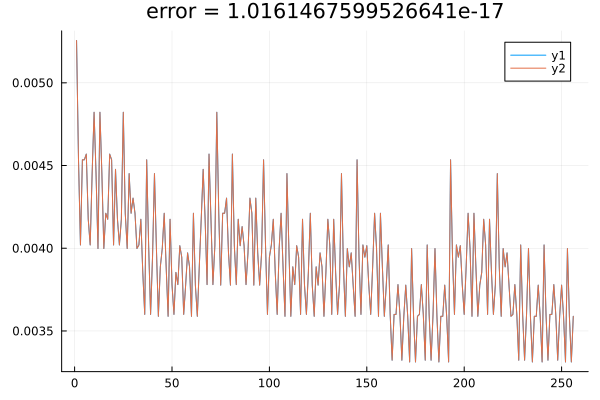

In [ ]:
N = 3
p = 0.4
syns = even_parity_matrices(N)
bMPS_ans = [contract_peps_no_phys(toric_peps(N,N,p,syns[i]);maxdim=64) for i in 1:length(syns)]
exact_ans = [dumbcontract_peps(toric_peps(N,N,p,syns[i])) for i in 1:length(syns)]

plot(title = "error = $(norm(bMPS_ans .- exact_ans))")
plot!(bMPS_ans)
plot!(exact_ans)


In [140]:
function mcmc_syndromes(N,p,num_samples;warm_start=2000,nflips=1,D=16)
    syn = rand(even_parity_matrices(N))
    maxiter = warm_start + num_samples 
    iter = 0
    syns = []
    probs = []
    p_old = contract_peps_no_phys(toric_peps(N,N,p,syn);maxdim=D)

    while iter < maxiter
        iter += 1 
        syn_dummy = copy(syn)
        
        for f = 1:nflips
            locX, locY = rand(1:N), rand(1:N) 
            locX1, locY1 = rand(1:N), rand(1:N) 
            syn_dummy[locX,locY] = 1 - syn_dummy[locX,locY]
            syn_dummy[locX1,locY1] = 1 - syn_dummy[locX1,locY1]
        end 

        p_new = contract_peps_no_phys(toric_peps(N,N,p,syn_dummy);maxdim=D)

        if p_new > p_old
            syn = syn_dummy
            p_old = p_new 
            push!(probs,p_new)
        else
            flipprob = p_new / p_old
            if rand() < flipprob
                syn = syn_dummy
                p_old = p_new 
                push!(probs,p_new)
            else
                syn = syn
                push!(probs,p_old)
            end
        end
        push!(syns,syn)
        
    end
    return syns[warm_start+1:end], probs[warm_start+1:end]
end 

mcmc_syndromes (generic function with 1 method)

In [142]:
function fi_attempt1(N, p, dp; ϵ=1e-12, nsamps=100, D=16)
    syns, probs_p = mcmc_syndromes(N, p, nsamps)
    probs_m = [contract_peps_no_phys(toric_peps(N,N,p+dp,syn);maxdim=D) for syn in syns]
    fi_vals = zeros(nsamps)
    for samp in 1:nsamps
        P_p = probs_p[samp]
        P_m = probs_m[samp]
        # print(P_p, " ", P_m, " ")
        fi_vals[samp] = ((log(P_p + ϵ) - log(P_m + ϵ)) / dp)^2
    end
    fi_mean = mean(fi_vals)
    fi_std = std(fi_vals)
    return fi_mean, fi_std
end

fi_attempt1 (generic function with 1 method)

In [ ]:
plot()
dp = 1e-3
ps = LinRange(0.05,0.3,30)

N = 3
fis_sampled = []
stds = []
@showprogress for p in ps 
    m, s = fi_attempt1(N,p,dp;ϵ=1e-12,nsamps=2000)
    push!(fis_sampled,m)
    push!(stds,s)
end 
plot!(ps,fis_sampled, label="N=$N")

N = 6
fis_sampled = []
stds = []
@showprogress for p in ps 
    m, s = fi_attempt1(N,p,dp;ϵ=1e-12,nsamps=2000)
    push!(fis_sampled,m)
    push!(stds,s)
end 
plot!(ps,fis_sampled, label="N=$N")


Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:00:02

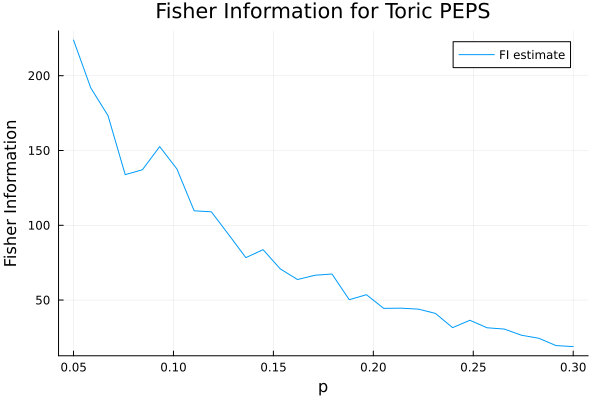

In [144]:
plot(ps,fis, label="FI estimate", xlabel="p", ylabel="Fisher Information", title="Fisher Information for Toric PEPS")

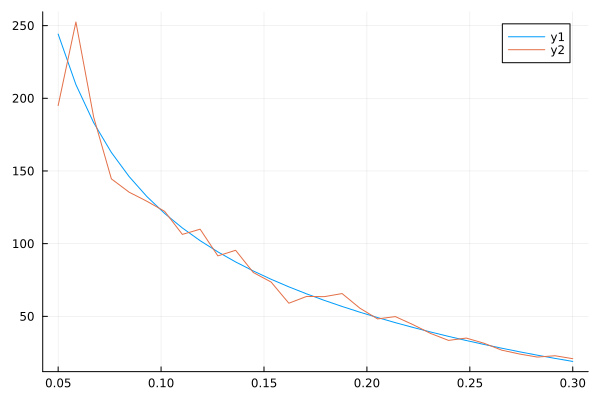

In [148]:
plot(ps,fis_exact)
plot!(ps,fis_sampled)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


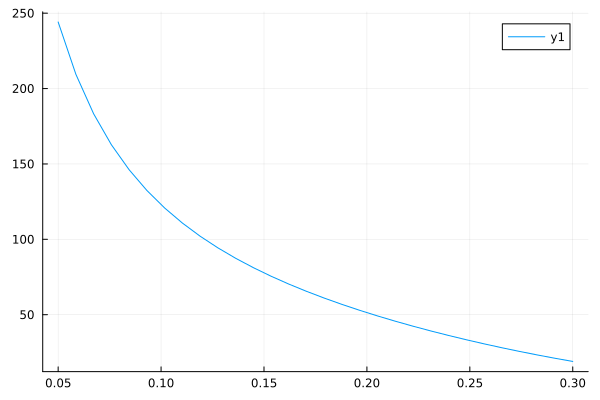

In [147]:
fis_exact = []
ϵ = 1e-12 

syns = even_parity_matrices(N)

@showprogress for p in ps 
    p0 = [contract_peps_no_phys(toric_peps(N,N,p,syn);maxdim=16) for syn in syns]
    pp = [contract_peps_no_phys(toric_peps(N,N,p+dp,syn);maxdim=16) for syn in syns]
    fi = sum((((log.(pp .+ ϵ) .- log.(p0 .+ ϵ)) ./ dp) .^ 2) .* p0)
    push!(fis_exact,fi)
end 
plot(ps,fis_exact)
